In [71]:
import warnings
warnings.filterwarnings('ignore')


import os
import sqlite3
import re
import nltk

 

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences


### Download the data

In [72]:
con = sqlite3.connect('/home/yura/PycharmProjects/news-filter/data/db/news_filter.db')

data = pd.read_sql_query("SELECT * FROM article", con)

### Data exploring

In [73]:
data.head()

,id,tittle,link,content,category
0,1,How her own illness led one woman to set up a ...,https://www.bbc.com/news/business-54088916,How her own illness led one woman to set up a ...,1.0
1,2,The boss who bounced her way to Â£3m from just...,https://www.bbc.com/news/business-53579590,The boss who bounced her way to Â£3m from just...,1.0
2,3,Ellesmere Port: Vauxhall plant pauses producti...,https://www.bbc.com/news/business-56300654,Ellesmere Port: Vauxhall plant pauses producti...,0.0
3,4,Covid: How Bracknell's Coral Reef pool looks i...,https://www.bbc.com/news/uk-england-berkshire-...,Covid: How Bracknell's Coral Reef pool looks i...,0.0
4,5,Covid-19: Young cancer patients on facing trea...,https://www.bbc.com/news/uk-northern-ireland-5...,Covid-19: Young cancer patients on facing trea...,0.0


In [74]:
data.shape

(1493, 5)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1493 entries, 0 to 1492
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        1493 non-null   int64  
 1   tittle    1493 non-null   object 
 2   link      1493 non-null   object 
 3   content   1493 non-null   object 
 4   category  796 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 58.4+ KB


In [76]:
data['category'].describe()

count    796.000000
mean       0.525126
std        0.499682
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: category, dtype: float64

In [77]:
data['category'].value_counts()

1.0    418
0.0    378
Name: category, dtype: int64

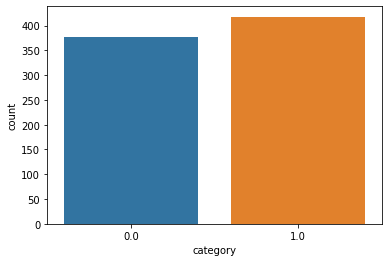

In [78]:
sns.countplot(data['category']);

### Data preprocessing

In [79]:
data.dropna(inplace=True)

In [80]:
data['category'] = data['category'].astype(int)

In [81]:
train, test = train_test_split(data, test_size = 0.3, random_state=1)


In [82]:
def remove_non_words(content):
    
    content = re.sub(r'[^\w\s]', '', text)
    content = re.sub(r'\d+', '', text)
    return content


def stem_text(text):
    stemmer = PorterStemmer()
    token_words = word_tokenize(text)
    stem_text = []
    for word in token_words:
        stem_text.append(stemmer.stem(word))
        stem_text.append(' ')
    return ''.join(stem_text)


def lemm_text(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(text)
    lemm_text = []
    for word in token_words:
        lemm_text.append(wordnet_lemmatizer.lemmatize(word))
        lemm_text.append(' ')
    return ''.join(lemm_text)
    

In [83]:


clean_train = []
clean_test = []
clean_new = []
for text in train['content']:
    clean_train.append(remove_non_words(text))
        
        
for text in test['content']:
    clean_test.append(remove_non_words(text))
    

'''for i, text in enumerate(clean_train):
    clean_train[i] = lemm_text(text)
    
    
for i, text in enumerate(clean_test):
    clean_test[i] = lemm_text(text)'''
    
        
for i, text in enumerate(clean_train):
    clean_train[i] = stem_text(text)
    
    
for i, text in enumerate(clean_test):
    clean_test[i] = stem_text(text)
  

### Feature extraction

TF-IDF vectorizer

In [84]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.8, min_df=2, sublinear_tf=True)

vectorizer.fit(clean_train)

X_train = vectorizer.transform(clean_train)

X_test = vectorizer.transform(clean_test)




Count Vectorizer

In [85]:
'''vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.8, min_df=2)

vectorizer.fit(clean_train)

X_train = vectorizer.transform(clean_train)

X_test = vectorizer.transform(clean_test)'''

"vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3), max_df=0.8, min_df=2)\n\nvectorizer.fit(clean_train)\n\nX_train = vectorizer.transform(clean_train)\n\nX_test = vectorizer.transform(clean_test)"

In [86]:
fselect = SelectKBest(chi2 , k=25000)
X_train = fselect.fit_transform(X_train, train['category'])
X_test = fselect.transform(X_test)

### Models

Logistic Regression

In [87]:
log_reg  = LogisticRegression(solver='liblinear', random_state=42, n_jobs=-1)

log_reg.fit(X_train, train['category'])

log_reg_predict = log_reg.predict(X_test)

accuracy_score(test['category'], log_reg_predict)

0.7531380753138075

In [88]:
precision_score(test['category'], log_reg_predict)

0.7633587786259542

In [89]:
recall_score(test['category'], log_reg_predict)

0.78125

In [90]:
f1_score(test['category'], log_reg_predict)

0.7722007722007723

In [91]:
roc_auc_score(test['category'], log_reg_predict)

0.7509853603603603

In [92]:
parameters = {'C': [1, 2, 3, 5, 6, 7, 8, 9, 10]}

log_reg_cv = GridSearchCV(LogisticRegression(solver='liblinear', random_state=42, n_jobs=-1), parameters)

log_reg_cv.fit(X_train, train['category'])

log_reg_predict_cv = log_reg_cv.predict(X_test)

accuracy_score(test['category'], log_reg_predict_cv)

0.7531380753138075

In [93]:
log_reg_cv.best_params_

{'C': 9}

Support Vector Classification

In [94]:
svc = SVC(kernel='linear', C=5, random_state=42)

svc.fit(X_train, train['category'])

svc_predict = svc.predict(X_test)

accuracy_score(test['category'], svc_predict)

0.7405857740585774

In [95]:
'''parameters = {'kernel': ('linear', 'rbf'),
              'C': [1, 2, 3, 5, 6, 7, 8, 9, 10]}

svc_cv = GridSearchCV(SVC(random_state=42), parameters)

svc_cv.fit(X_train, train['category'])

svc_predict_cv = svc_cv.predict(X_test)

accuracy_score(test['category'], svc_predict_cv)'''

"parameters = {'kernel': ('linear', 'rbf'),\n              'C': [1, 2, 3, 5, 6, 7, 8, 9, 10]}\n\nsvc_cv = GridSearchCV(SVC(random_state=42), parameters)\n\nsvc_cv.fit(X_train, train['category'])\n\nsvc_predict_cv = svc_cv.predict(X_test)\n\naccuracy_score(test['category'], svc_predict_cv)"

In [96]:
'''svc_cv.best_params_'''

'svc_cv.best_params_'

Naive Bayes

In [97]:
bayes_clf = MultinomialNB()

bayes_clf.fit(X_train, train['category'])

bayes_clf_predict = bayes_clf.predict(X_test)

accuracy_score(test['category'], bayes_clf_predict)

0.7489539748953975

In [98]:

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input


In [99]:
model = Sequential()
model.add(Dense(32,input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(4, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                800032    
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 800,337
Trainable params: 800,337
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(X_train.toarray(), train['category'].values, validation_split=0.2, epochs=20, verbose=0)

In [102]:
model.evaluate(X_test.toarray(), test['category'].values, verbose=False)

[1.0805119276046753, 0.581589937210083]

In [103]:
'''
model = Sequential()
model.add(Dense(500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])'''

"\nmodel = Sequential()\nmodel.add(Dense(500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))\nmodel.add(Dense(1, activation='sigmoid'))\n\nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])"

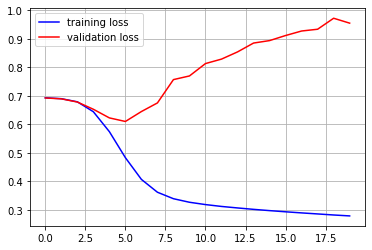

In [104]:
plt.plot(history.history['loss'], 'b', label='training loss')
plt.plot(history.history['val_loss'], 'r', label='validation loss')
plt.legend()
plt.grid(True)
plt.show;

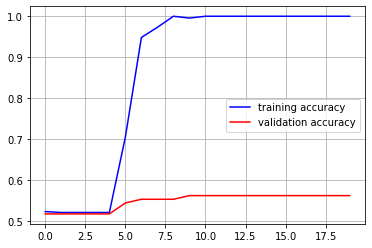

In [105]:
plt.plot(history.history['accuracy'], 'b', label='training accuracy')
plt.plot(history.history['val_accuracy'], 'r', label='validation accuracy')
plt.legend()
plt.grid(True)
plt.show;